Используйте базу акций Лукойла.

Сделайте несколько усовершенствований в предсказании временного ряда.
Добавьте к исходному сигналу расширенные данные:

* попарные разности каналов
* модули попарных разностей каналов
* попарные произведения каналов
* обратное значение каналов x_new = 1/(x + 1e-3)
* первые производные каналов (x[n] - x[n-1])
* вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])

Примените абсолютно новый подход. Сделайте бОльший “просмотр сети в прошлое”, при формировании входного сигнала используйте:

* 100 точек с шагом назад по 1,

* 100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек).
* Объедините эти точки

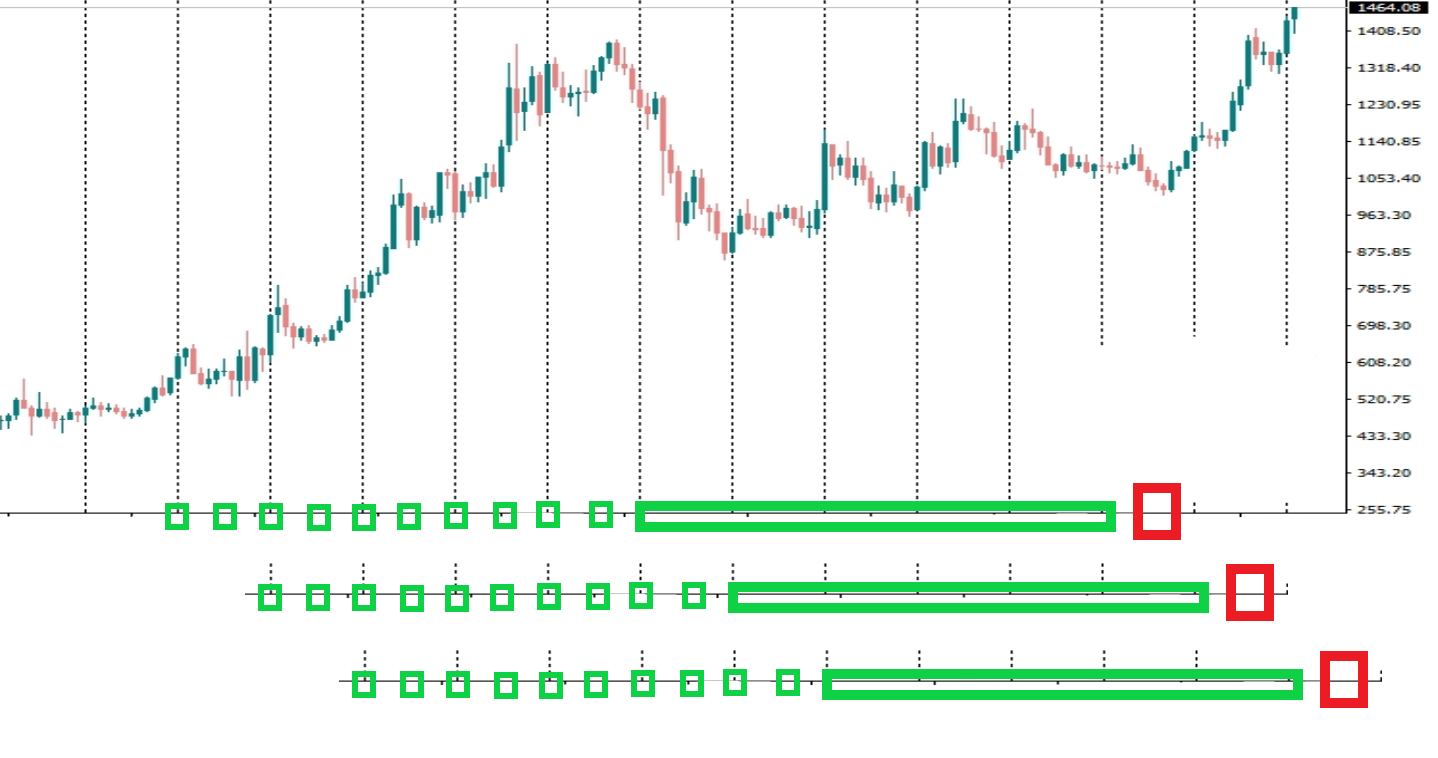

## Подготовка

In [ ]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, MaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Коллбэк
from tensorflow.keras.callbacks import LearningRateScheduler

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Назначение размера и стиля графиков по умолчанию

from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

In [ ]:
# Загрузка датасетов из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

'18_19.csv'

In [ ]:
# Чтение данных в таблицы с удалением ненужных столбцов

data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

In [ ]:
# Просмотр размерностей получившихся таблиц

print(data16_17.shape)
print(data18_19.shape)

(263925, 5)
(217947, 5)


In [ ]:
# Создание общего набора данных из двух датасетов

data = pd.concat([data16_17,data18_19])   # Объединение датасетов
data = data.reset_index(drop = True)      # Обнуление индексов

# Проверка формы данных
print(data.shape)

(481872, 5)


In [ ]:
# Получение названий столбцов

col = data.columns
print(col)

Index(['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME'], dtype='object')


# Решение 1 части задания:
Сделайте несколько усовершенствований в предсказании временного ряда.
Добавьте к исходному сигналу расширенные данные:

* попарные разности каналов
* модули попарных разностей каналов
* попарные произведения каналов
* обратное значение каналов x_new = 1/(x + 1e-3)
* первые производные каналов (x[n] - x[n-1])
* вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])

In [ ]:
# Задание циклов для столбцов таким образом, чтобы происходил перебор всех возможных пар:
# Перебор индексов массива с именами столбцов 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME',
# получая пары 'OPEN' и 'MAX', 'OPEN' и 'MIN', 'OPEN' и 'CLOSE' ..., 'MAX' и 'MIN', 'MAX' и 'CLOSE' и т.д

for i in range(col.shape[0]): # Для всех пар
    for j in range(i + 1 , col.shape[0]): # Расчет
        data[col[i] + '-' + col[j]] = data[col[i]] - data[col[j]] # Разности
        data['|' + col[i] + '-' + col[j] + '|'] = abs(data[col[i]] - data[col[j]]) # Модулей разностей
        data[col[i] + '*' + col[j]] = data[col[i]] * data[col[j]] # Произведения

# Для каждого столбца 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME' расчет:
for i in col:
    # Обратные значения. 1e-3 в формуле нужно, чтобы случайно не разделить на 0
    data['Обратный ' + i] = 1 / (data[i] + 1e-3)
    # Создание пустого столбца
    data['Производная от ' + i] = np.nan
    # При помощи срезов расчет первых производных, .reset_index(drop=True) нужен для корректных расчетов
    data['Производная от ' + i][1:] = data[i][1:].reset_index(drop=True) - data[i][:-1].reset_index(drop=True)
    # Создание пустого столбца
    data['Вторая производная от ' + i] = np.nan
    # При помощи срезов расчет вторых производных
    data['Вторая производная от ' + i][2:] = data[i][2:].reset_index(drop=True) - 2 * data[i][1:-1].reset_index(drop=True) + data[i][:-2].reset_index(drop=True)


In [ ]:
# Просмотр результатов
data

,OPEN,MAX,MIN,CLOSE,VOLUME,OPEN-MAX,|OPEN-MAX|,OPEN*MAX,OPEN-MIN,|OPEN-MIN|,...,Вторая производная от MAX,Обратный MIN,Производная от MIN,Вторая производная от MIN,Обратный CLOSE,Производная от CLOSE,Вторая производная от CLOSE,Обратный VOLUME,Производная от VOLUME,Вторая производная от VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547,-4.8,4.8,5538485.80,1.0,1.0,...,NaN,0.000426,NaN,NaN,0.000426,NaN,NaN,0.000393,NaN,NaN
1,2352.9,2355.7,2350.0,2355.7,195,-2.8,2.8,5542726.53,2.9,2.9,...,NaN,0.000426,0.0,NaN,0.000425,5.7,NaN,0.005128,-2352.0,NaN
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,0.4,5549793.60,4.2,4.2,...,0.4,0.000425,1.4,1.4,0.000425,-1.6,-7.3,0.003891,62.0,2414.0
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,0.5,5544847.50,3.3,3.3,...,-1.3,0.000425,-0.2,-1.6,0.000425,-0.4,1.2,0.001311,506.0,444.0
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.8,5538962.09,0.0,0.0,...,-0.1,0.000425,1.9,2.1,0.000425,-0.1,0.3,0.004329,-532.0,-1038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481867,5183.5,5183.5,5183.5,5183.5,31523,0.0,0.0,26868672.25,0.0,0.0,...,11.5,0.000193,16.0,18.0,0.000193,11.5,10.0,0.000032,29174.0,29480.0
481868,5183.5,5183.5,5183.5,5183.5,5090,0.0,0.0,26868672.25,0.0,0.0,...,-11.5,0.000193,0.0,-16.0,0.000193,0.0,-11.5,0.000196,-26433.0,-55607.0
481869,5183.5,5183.5,5183.5,5183.5,230,0.0,0.0,26868672.25,0.0,0.0,...,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.004348,-4860.0,21573.0
481870,5183.5,5183.5,5183.5,5183.5,5,0.0,0.0,26868672.25,0.0,0.0,...,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.199960,-225.0,4635.0


In [ ]:
# Использование всех столбцов, кроме первых двух
data = np.array(data.iloc[2:])

# Перевод в numpy
data = np.array(data)

# Переменная, для использования одной и той же архитектуры под разные матрицы
columnsamount = data.shape[1]

# Решение 2 части задания

Создание TimeseriesGenerator отвечающего заданию:
*   100 точек с шагом назад по 1,
*   100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек).
*   Объедините эти точки




In [ ]:
#Ваше решение

import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import timeseries_dataset_from_array

# Загрузка данных
data = np.random.rand(481870, 50)

# Создание второго TimeseriesGenerator
gen_10 = TimeseriesGenerator(data, data[:, 3], length=1100, sampling_rate=11, stride=10, batch_size=1)

# Создание первого TimeseriesGenerator
gen_1 = TimeseriesGenerator(data, data[:, 3], length=100, sampling_rate=1, stride=1, batch_size=1)

# Объединение точек из двух генераторов
combined_x_data = []
combined_y_data = []

for (x1, y1), (x2, y2) in zip(gen_10, gen_1):
    combined_x = np.vstack((x1[0], x2[0]))
    combined_y = y1  # Оставляем y1 без изменений
    combined_x_data.append(combined_x)
    combined_y_data.append(combined_y)

# Преобразование объединенных точек в numpy array
combined_x_data = np.array(combined_x_data)
combined_y_data = np.array(combined_y_data)

# Сохранение результатов в переменные
first_tsg = gen_10
second_tsg = gen_1

# Вывод размерности результатов
print("100 точек с шагом назад по 1:")
print(first_tsg[0][0].shape)
print(first_tsg[0][1].shape)
print("\n100 точек с шагом назад по 10:")
print(second_tsg[0][0].shape)
print(second_tsg[0][1].shape)
print("Объединённые точки для формировании входного сигнала:")
print(combined_x_data.shape)

100 точек с шагом назад по 1:
(1, 100, 50)
(1,)

100 точек с шагом назад по 10:
(1, 100, 50)
(1,)
Объединённые точки для формировании входного сигнала:
(48077, 200, 50)


# Исследования

In [ ]:
# Просмотр результатов
data

array([[ 2.35560000e+03,  2.35600000e+03,  2.35140000e+03, ...,
         3.89103544e-03,  6.20000000e+01,  2.41400000e+03],
       [ 2.35450000e+03,  2.35500000e+03,  2.35120000e+03, ...,
         1.31061427e-03,  5.06000000e+02,  4.44000000e+02],
       [ 2.35310000e+03,  2.35390000e+03,  2.35310000e+03, ...,
         4.32898559e-03, -5.32000000e+02, -1.03800000e+03],
       ...,
       [ 5.18350000e+03,  5.18350000e+03,  5.18350000e+03, ...,
         4.34780718e-03, -4.86000000e+03,  2.15730000e+04],
       [ 5.18350000e+03,  5.18350000e+03,  5.18350000e+03, ...,
         1.99960008e-01, -2.25000000e+02,  4.63500000e+03],
       [ 5.18350000e+03,  5.18350000e+03,  5.18350000e+03, ...,
         1.00603521e-03,  9.89000000e+02,  1.21400000e+03]])

In [ ]:
data.shape

(481870, 50)

In [ ]:
# Объединение точек: w + w*lr*loss
# w*lr*loss: это изменение веса, вычисленное на основе градиента функции потерь по отношению к весам модели.
# w + w*lr*loss: это новое значение веса, которое получается путем добавления этого изменения к текущему значению веса.
# Таким образом, выражение: "w + w*lr*loss" означает обновление весов модели с учетом скорости обучения и значения функции потерь.

length – длина выходных последовательностей, окно, которым вы пройдетесь по данным.

sampling_rate – размер шага при выборке данных в x_train. Если x_train последовательность от 0 до 50, то

при rate=1 последовательность выглядит так:

  [0, 1, 2, 3, 4].

При rate=2 в последовательность попадет каждый второй элемент:

  [0, 2, 4, 6, 8]
и так далее.

stride – указывает, на сколько элементов произойдет сдвиг при смене элемента. У того же x_train при stride=1 первый и второй элемент выглядят так:

  [0, 1, 2, 3, 4, 5] [1, 2, 3, 4, 5, 6].

  При stride=2:

  [0, 1, 2, 3, 4, 5] [2, 3, 4, 5, 6, 7].
batch_size – сколько элементов вернет генератор при обращении к нему

In [ ]:
# Задание текстовых меток каналов данных (столбцов)
CHANNEL_NAMES = ['Open', 'Max', 'Min', 'Close', 'Volume']

# Получение словаря с именами и индексами каналов данных
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}
print(CHANNEL_INDEX)

{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}


In [ ]:
# Отображение исходных данных от точки start и длиной length
start = 100
length = 300

# Задание полотна для графиков - два подграфика один под другим с общей осью x
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(22, 13), sharex=True)

# Четыре основных канала - open, max, min, close
for chn in range(4):
    # Отрисовка одного канала данных
    # От начальной точки start длиной length
    ax1.plot(data[start:start + length, chn],
             label=CHANNEL_NAMES[chn])
ax1.set_ylabel('Цена, руб')
ax1.legend()

# Канал volume (объем)
ax2.bar(x=np.arange(length),
        height=data[start:start + length, CHANNEL_INDEX['Volume']],
        label='Объем')
ax2.set_ylabel('Сделки')
ax2.legend()

plt.xlabel('Время')
# Регулировка пределов оси x
plt.xlim(0, length)
# Указание расположить подграфики плотнее друг к другу
plt.tight_layout()
# Фиксация графика
plt.show()

In [ ]:
# Вывод первых строк таблицы
data.head()

In [ ]:
# Функция создания пробного генератора и вывода его результатов на экран
# На входе - имитация выборок x_train, y_train
def show_gen(x_train, y_train, length=100, batch_size=1):
    # Создание генератора TimeseriesGenerator
    gen = TimeseriesGenerator(x_train,
                              y_train,
                              length=length,
                              sampling_rate=10,
                              stride=1,
                              batch_size=batch_size
                             )

    # Прохождение по элементам генератора (батчам) в цикле и вывод каждого батча
    for i, g in enumerate(gen):
        print('Батч №', i)
        print('x_train:\n', g[0])
        print('y_train:\n', g[1])
        print()

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

# Параметры генератора
length = 100
sampling_rate = 1
stride = 1
batch_size = 1

# Генерация TimeseriesGenerator для первых 100 точек с шагом назад по 1
gen_1 = TimeseriesGenerator(data, data[:, 3], length=length, sampling_rate=sampling_rate, stride=stride, batch_size=batch_size)

# Генерация TimeseriesGenerator для следующих 100 точек с шагом назад по 10
sampling_rate = 10
gen_10 = TimeseriesGenerator(data, data[:, 3], length=length, sampling_rate=sampling_rate, stride=stride, batch_size=batch_size)

# Объединение точек внутри цикла
combined_data = []
for (x1, y1), (x2, y2) in zip(gen_1, gen_10):
    combined_data.append(np.concatenate((x1[0], x2[0])))

# Необходимо преобразовать в numpy array
combined_data = np.array(combined_data)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import timeseries_dataset_from_array

# Загрузка данных
# data = np.random.rand(481870, 50)

# Создание первого TimeseriesGenerator
gen_10 = TimeseriesGenerator(data, data[:, 3], length=100, sampling_rate=10, stride=10, batch_size=1)

# Создание второго TimeseriesGenerator
gen_1 = TimeseriesGenerator(data, data[:, 3], length=100, sampling_rate=1, stride=1, batch_size=1)


# Объединение точек из двух генераторов
combined_data = []
for (x1, y1), (x2, y2) in zip(gen_10, gen_1):
    combined_data.append(np.concatenate((x1[0], x2[0])))

# Преобразование объединенных точек в numpy array
combined_data = np.array(combined_data)

# Создание TimeseriesDataset из объединенных точек
dataset = timeseries_dataset_from_array(combined_data, combined_data[:, 3], sequence_length=200, batch_size=1)

In [ ]:
len(data)

481870

In [ ]:
len(dataset)

47978

In [ ]:
len(combined_data)

48177

In [ ]:
len(gen_1)

481770

In [ ]:
len(gen_10)

48177

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import timeseries_dataset_from_array

# Загрузка данных
# data = np.random.rand(481870, 50)

# Создание первого TimeseriesGenerator
gen_1 = TimeseriesGenerator(data, data[:, 3], length=100, sampling_rate=1, stride=1, batch_size=1)

# Создание второго TimeseriesGenerator
gen_10 = TimeseriesGenerator(data, data[:, 3], length=100, sampling_rate=10, stride=10, batch_size=1)

# Объединение точек из двух генераторов
combined_data = []
for (x1, y1), (x2, y2) in zip(gen_1, gen_10):
    combined_data.append(np.concatenate((x1[0], x2[0])))

# Преобразование объединенных точек в numpy array
combined_data = np.array(combined_data)

# Сохранение результатов в переменные
first_tsg = gen_1
second_tsg = gen_10
combined_tsg = combined_data

# Вывод суммаризации результатов
print("First TimeseriesGenerator summary:")
print(first_tsg.summary())
print("\nSecond TimeseriesGenerator summary:")
print(second_tsg.summary())
print("\nCombined data summary:")
print(combined_tsg.summary())

First TimeseriesGenerator summary:


AttributeError: 'TimeseriesGenerator' object has no attribute 'summary'

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import timeseries_dataset_from_array

# Загрузка данных
data = np.random.rand(481870, 50)

# Создание первого TimeseriesGenerator
gen_1 = TimeseriesGenerator(data, data[:, 3], length=100, sampling_rate=1, stride=1, batch_size=1)

# Создание второго TimeseriesGenerator
gen_10 = TimeseriesGenerator(data, data[:, 3], length=100, sampling_rate=10, stride=10, batch_size=1)

# Объединение точек из двух генераторов
combined_data = []
for (x1, y1), (x2, y2) in zip(gen_1, gen_10):
    combined_data.append(np.concatenate((x1[0], x2[0])))

# Преобразование объединенных точек в numpy array
combined_data = np.array(combined_data)

# Сохранение результатов в переменные
first_tsg = gen_1
second_tsg = gen_10
combined_tsg = combined_data

# Вывод размерности результатов
print("First TimeseriesGenerator shape:")
print(first_tsg[0][0].shape)
print(first_tsg[0][1].shape)
print("\nSecond TimeseriesGenerator shape:")
print(second_tsg[0][0].shape)
print(second_tsg[0][1].shape)
print("\nCombined data shape:")
print(combined_tsg.shape)

First TimeseriesGenerator shape:
(1, 100, 50)
(1,)

Second TimeseriesGenerator shape:
(1, 10, 50)
(1,)

Combined data shape:
(48177, 110, 50)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import timeseries_dataset_from_array

# Создание второго TimeseriesGenerator
gen_10 = TimeseriesGenerator(data, data[:, 3], length=100, sampling_rate=10, stride=10, batch_size=1)

# Создание первого TimeseriesGenerator
gen_1 = TimeseriesGenerator(data, data[:, 3], length=100, sampling_rate=1, stride=1, batch_size=1)

# Объединение точек из двух генераторов
combined_data = []
for (x1, y1), (x2, y2) in zip(gen_10, gen_1):
    combined_data.append(np.concatenate((x1[0], x2[0])))

# Преобразование объединенных точек в numpy array
combined_data = np.array(combined_data)

# Сохранение результатов в переменные
first_tsg = gen_10
second_tsg = gen_1
combined_tsg = combined_data

# Вывод размерности результатов
print("First TimeseriesGenerator shape:")
print(first_tsg[0][0].shape)
print(first_tsg[0][1].shape)
print("\nSecond TimeseriesGenerator shape:")
print(second_tsg[0][0].shape)
print(second_tsg[0][1].shape)
print("\nCombined data shape:")
print(combined_tsg.shape)

First TimeseriesGenerator shape:
(1, 10, 50)
(1,)

Second TimeseriesGenerator shape:
(1, 100, 50)
(1,)

Combined data shape:
(48177, 110, 50)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import timeseries_dataset_from_array

# Загрузка данных
data = np.random.rand(481870, 50)

# Создание второго TimeseriesGenerator
gen_10 = TimeseriesGenerator(data, data[:, 3], length=100, sampling_rate=10, stride=10, batch_size=1)

# Создание первого TimeseriesGenerator
gen_1 = TimeseriesGenerator(data, data[:, 3], length=100, sampling_rate=1, stride=1, batch_size=1)



# Объединение точек из двух генераторов
combined_x_data = []
combined_y_data = []

for (x1, y1), (x2, y2) in zip(gen_10, gen_1):
    combined_x = np.vstack((x1[0], x2[0]))
    combined_y = y1  # Оставляем y1 без изменений
    combined_x_data.append(combined_x)
    combined_y_data.append(combined_y)

# Преобразование объединенных точек в numpy array
combined_x_data = np.array(combined_x_data)
combined_y_data = np.array(combined_y_data)

# Сохранение результатов в переменные
first_tsg = gen_10
second_tsg = gen_1
combined_tsg = combined_data
# Вывод размерности результатов
print("First TimeseriesGeneratorshape:")
print(first_tsg[0][0].shape)
print(first_tsg[0][1].shape)
print("\nSecond TimeseriesGeneratorshape:")
print(second_tsg[0][0].shape)
print(second_tsg[0][1].shape)
# print("\nCombined data shape:")
# print(combined_tsg.shape)


print("Combined x data shape:")
print(combined_x_data.shape)
print("Combined y data shape:")
print(combined_y_data.shape)

First TimeseriesGeneratorshape:
(1, 10, 50)
(1,)

Second TimeseriesGeneratorshape:
(1, 100, 50)
(1,)
Combined x data shape:
(48177, 110, 50)
Combined y data shape:
(48177, 1)
